In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import csv

import numpy as np

from tqdm import trange
from statistics import mean

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

import nltk
nltk.download("stopwords")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/some-topics'

Mounted at /content/drive


In [82]:
# ALL PARAMETERS
number_of_takes = 600
take_rows = 20

words_in_sentence = 300

CONTEXT_SIZE = 2
EMBEDDING_DIM = 300
N_HIDDEN_LAYERS = 1
BIDIRECTIONAL = True
lr = 0.07

BS = 10
epochs = 40
device = 'cuda' if torch.cuda.is_available() else 'cpu'

text = pd.read_csv(f'{PATH}/modified.csv', nrows =1)
columns = text.columns

# Load model to take embedding matrix

In [5]:
class CBOWModeler(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModeler, self).__init__()
        self.linear1 = nn.Linear(vocab_size, embedding_dim)
        self.linear2 = nn.Linear(embedding_dim, vocab_size)


    def forward(self, inputs):
        emb = self.linear1(inputs)
        out_s_layer = self.linear2(emb)

        # print(out_s_layer.shape)
        log_probs = F.log_softmax(out_s_layer, dim=0)
        return log_probs


    def predict(self, input, null_vector):
        context_vec = null_vector.copy()
        for word in input:
            context_vec[word] = 1;
        context_vec = list(context_vec.values())

        context_tensor = torch.tensor(context_vec, dtype=torch.float).to(device)
        res = self.forward(context_tensor)
        print(res.shape)
        res_arg = torch.argmax(res).item()

        return list(null_vector.keys())[res_arg]


    def write_embedding_to_file(self,filename):
        for i in self.embeddings.parameters():
            weights = i.cpu().data.numpy()
        np.save(filename,weights)


    def write_linear_to_file(self,filename):
        for i in self.linear2.parameters():
            weights = i.cpu().data.numpy()
        np.save(filename,weights)

In [6]:
null_vector = pd.read_csv(f'{PATH}/alphabet_full_text.csv').to_dict(orient='records')[0]

model = CBOWModeler(len(null_vector), EMBEDDING_DIM)
model.load_state_dict(torch.load(f'{PATH}/model_full_text', map_location=torch.device(device)))

emb_matrix = [i for i in model.linear1.parameters()][0]
emb_matrix = emb_matrix.cpu().detach().numpy()

In [72]:
text = pd.read_csv(f'/{PATH}/modified.csv', nrows =number_of_takes*take_rows)
n_classes = len(set(text['label']))

[76, 82, 87, 91, 92] . . .


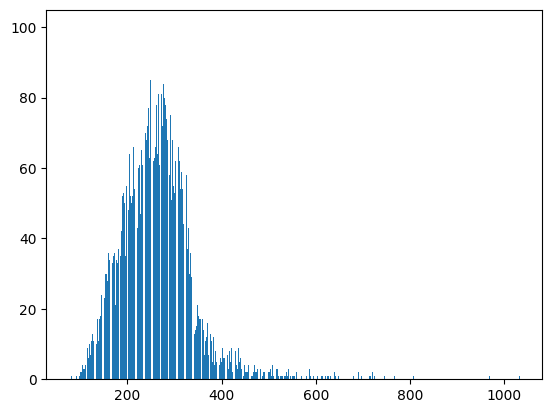

In [61]:
sentence_len = {}
for row in range(len(text['edited'])):
  ln = len(text['edited'][row])
  if ln in sentence_len.keys():
    sentence_len[ln] += 1
  else:
    sentence_len[ln] = 1

sentence_len = dict(sorted(sentence_len.items()))
groups = sentence_len.keys()
values = sentence_len.values()

plt.bar(groups, values)
print(list(groups)[:5], ". . .")

# Вычисляем эмбеддинги для всего алфавита

In [73]:
words_emb = null_vector.copy()

for w in null_vector.keys():
    word = null_vector.copy()
    if (w in word.keys()): word[w] = 1
    word = np.array(list(word.values()))

    word2vec = np.matmul(emb_matrix, word)
    words_emb[w] = word2vec
words_emb['UNK'] = [0]*EMBEDDING_DIM

In [74]:
columns_for_vec = [i for i in range(EMBEDDING_DIM)]
vectors = {}

for row in trange(number_of_takes*take_rows):
    vectors[row] = []
    c_words = 0

    for word in eval(text['edited'][row]):
        if c_words == words_in_sentence: break
        if word in words_emb.keys():
            vectors[row].append(words_emb[word])
            c_words += 1

    while c_words < words_in_sentence:
        vectors[row].append(words_emb['UNK'])
        c_words += 1

100%|██████████| 12000/12000 [00:02<00:00, 5734.59it/s]


In [10]:
class MyDataset(Dataset):

  def __init__(self, df, targets):
    self.vectors = torch.tensor(df['vectors'], dtype=torch.float32)
    self.target = torch.tensor(targets)

  def __len__(self):
    return len(self.target)

  def __getitem__(self,idx):
    return self.vectors[idx], self.target[idx]



columns_for_vec = [i for i in range(EMBEDDING_DIM)]
vectors = {}

for row in trange(number_of_takes*take_rows):
    # w = [0]*EMBEDDING_DIM
    vectors[row] = []
    c_words = 0
    for word in eval(text['edited'][row]):
        if c_words == words_in_sentence: break
        if word in words_emb.keys():
            vectors[row].append(words_emb[word])
            # w += words_emb[word]
            c_words += 1
        # vectors[row] = w

    while c_words < words_in_sentence:
        vectors[row].append(words_emb['UNK'])
        c_words += 1

vectors = pd.DataFrame(vectors.items(), columns=['id', 'vectors'])
data = MyDataset(vectors, text['label'])

100%|██████████| 12000/12000 [00:01<00:00, 11866.75it/s]
<ipython-input-10-d7a954c8506b>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  self.vectors = torch.tensor(df['vectors'], dtype=torch.float32)


# Prepare RNN model

In [83]:
model = nn.LSTM(
    input_size=EMBEDDING_DIM,
    hidden_size=n_classes,
    num_layers=N_HIDDEN_LAYERS,
    bidirectional=BIDIRECTIONAL,
    batch_first=True,
)

model.to(device)

LSTM(300, 4, batch_first=True, bidirectional=True)

In [12]:
generator = torch.Generator()
generator.manual_seed(0)

train_set, val_set = torch.utils.data.random_split(data, [int(0.8*number_of_takes*take_rows), int(0.2*number_of_takes*take_rows)], generator=generator)

In [86]:
optimizer = optim.Adam(model.parameters(), lr)
loss_function = nn.CrossEntropyLoss()

N_BATCH = int(len(train_set)/BS)

for ep in trange(epochs):
    total_loss = 0

    for batch in range(N_BATCH):
        optimizer.zero_grad()
        train = train_set[batch*BS:(batch+1)*BS]

        out, hidden = model(torch.tensor(train[0], dtype=torch.float).to(device))
        res = hidden[1]

        res = res.mean(dim=0)
        # print(res)

        loss = loss_function(res, torch.tensor(train[1], dtype=torch.long).to(device))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    if ep % 5 == 0:
        print(total_loss/N_BATCH, '\n')

total_loss/N_BATCH

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-86-1da60efeac9f>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out, hidden = model(torch.tensor(train[0], dtype=torch.float).to(device))
<ipython-input-86-1da60efeac9f>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_function(res, torch.tensor(train[1], dtype=torch.long).to(device))
  5%|▌         | 1/20 [00:02<00:45,  2.41s/it]

0.41414738511278604 



 30%|███       | 6/20 [00:14<00:36,  2.58s/it]

0.3762976439689131 



 55%|█████▌    | 11/20 [00:27<00:23,  2.57s/it]

0.3402778576496833 



 80%|████████  | 16/20 [00:39<00:09,  2.45s/it]

0.316960610585132 



100%|██████████| 20/20 [00:49<00:00,  2.46s/it]


0.30064367927843705

<ipython-input-87-c1a90d62f1be>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out, hidden = model(torch.tensor(val_set[:][0], dtype=torch.float).to(device))


torch.Size([2400, 4])
acc:  0.8108333333333333


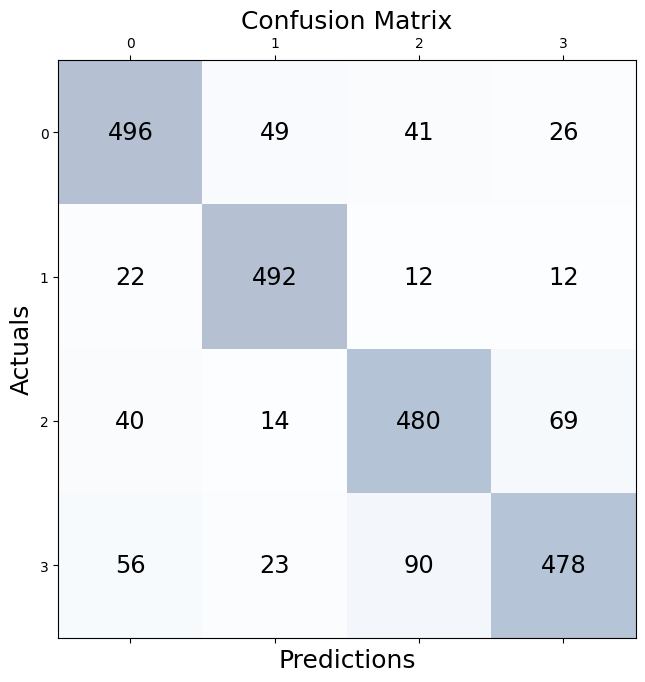

In [87]:
out, hidden = model(torch.tensor(val_set[:][0], dtype=torch.float).to(device))
res = hidden[1]
res = res.mean(dim=0)

preds = res.cpu().argmax(-1).detach().numpy()
print(res.shape)
print("acc: ", accuracy_score(val_set[:][1], preds))

conf_matrix = confusion_matrix(y_true=val_set[:][1], y_pred=preds)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()